# Problem Statement

The Travelling Salesman Problem is another combinatorial search problem which has each path through the cities represented as a state and all possible paths as the state space.

Problem name: bayg29
Optimal solution =  [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
Optimal distance =  9074.147


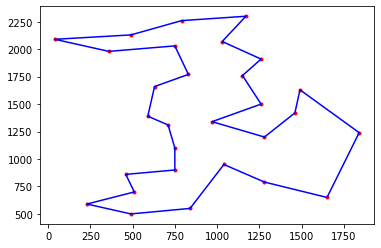

In [1]:
import numpy as np
import csv, pickle, os, codecs, random
from urllib.request import urlopen
import matplotlib.pyplot as plt

class TSP:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from an online file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.
    :param name: The name of the corresponding TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """
    def __init__(self, name):
        """
        Creates an instance of a TSP
        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the serialized data, and if not available - calls __create_data() to prepare it
        """

        # attempt to read serialized data:
        try:
            self.locations = pickle.load(open(os.path.join("tsp-data", self.name + "-loc.pickle"), "rb"))
            self.distances = pickle.load(open(os.path.join("tsp-data", self.name + "-dist.pickle"), "rb"))
        except (OSError, IOError):
            pass

        # serailized data not found - create the data from scratch:
        if not self.locations or not self.distances:
            self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file from the Internet, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        It then serializes the city locations and the calculated distances to disk using the pickle utility.
        """
        self.locations = []

        # open whitespace-delimited file from url and read lines from it:
        with urlopen("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + self.name + ".tsp") as f:
            reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))

            # serialize locations and distances:
            if not os.path.exists("tsp-data"):
                os.makedirs("tsp-data")
            pickle.dump(self.locations, open(os.path.join("tsp-data", self.name + "-loc.pickle"), "wb"))
            pickle.dump(self.distances, open(os.path.join("tsp-data", self.name + "-dist.pickle"), "wb"))

    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities
        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices):
        """plots the path described by the given indices of the cities
        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.scatter(*zip(*self.locations), marker='.', color='red')

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')

        return plt


# testing the class:
def main():
    # create a problem instance:
    tsp = TSP("bayg29")

    # generate a random solution and evaluate it:
    randomSolution = random.sample(range(len(tsp)), len(tsp))

    # see http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.opt.tour
    optimalSolution = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]

    print("Problem name: " + tsp.name)
    print("Optimal solution = ", optimalSolution)
    print("Optimal distance = ", tsp.getTotalDistance(optimalSolution))

    # plot the solution:
    plot = tsp.plotData(optimalSolution)
    plot.show()
    
main()

# Genetic Algorithm

In [2]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random, array
import seaborn as sns

toolbox = base.Toolbox()

TSP_NAME = "bayg29"
tsp = TSP(TSP_NAME)

# Initialize constants
POPULATION_SIZE = 300
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 1
P_CROSSOVER = 0.9
P_MUTATION = 0.1

random.seed(42)

## Chromosome type

As our solution will be in the form of ordered cities, we can represent our chromosomes into an array of n-integers like [0, 1, 2, 3, 4 ,5] or [2, 4, 3, 1, 0] that dictates which cities will be visited in order.

The `randomOrder` operator will generate a random list of n-integers of range 0 and n-1.

In [3]:
toolbox.register(
    alias="randomOrder",
    function=random.sample,
    population=range(len(tsp)),
    k=len(tsp)
)

## Fitness Strategy

We chose minimizing fitness strategy as we are trying to get the shortest distance and cost for the problem.

In [4]:
creator.create(
    name="FitnessMin",
    base=base.Fitness,
    weights=(-1.0,)
)

## Population Generator

In [5]:
creator.create(
    name="Individual",
    base=array.array,
    typecode='i',
    fitness=creator.FitnessMin
)

toolbox.register(
    alias="individualCreator",
    function=tools.initIterate,
    container=creator.Individual,
    generator=toolbox.randomOrder
)

toolbox.register(
    alias="populationCreator",
    function=tools.initRepeat,
    container=list,
    func=toolbox.individualCreator
)

## Evaluation Function

In [6]:
def tspDistance(individual):
    return tsp.getTotalDistance(individual),

toolbox.register(
    alias="evaluate",
    function=tspDistance
)

## Genetic operators

In [7]:
# Selection
"""
Reducing tournament size increases exploration effect,
this means that weaker individuals have higher chance
to survive for longer generations as they will not be
dropped off as early.
"""
toolbox.register(
    alias="select",
    function=tools.selTournament,
    tournsize=2,
)

# Crossover
"""
Ordered crossover is used here as no repetition 
in the indices is allowed and also the preserve the 
ordering of the genes as much as possible.
"""
toolbox.register(
    alias="mate",
    function=tools.cxOrdered   
)

# Mutation
toolbox.register(
    alias="mutate",
    function=tools.mutShuffleIndexes,
    indpb=(1.0/len(tsp))
)

## Integrate

gen	nevals	min    	avg  
0  	300   	21103.3	26457
1  	277   	20664.5	25415
2  	263   	19963  	24975.2
3  	288   	19966.1	24400.4
4  	284   	18990.6	24204.4
5  	266   	18990.6	23826.6
6  	270   	17101.2	23630  
7  	273   	19158.7	23281.9
8  	279   	16829.4	23186.7
9  	267   	16829.4	22908.8
10 	273   	17107.5	22708.4
11 	266   	17612.6	22555.1
12 	268   	17208.7	22361.1
13 	281   	15858  	22134.9
14 	276   	16883.6	21969.9
15 	281   	16988.7	21684.6
16 	275   	17584.4	21693.9
17 	270   	16264.1	21531.8
18 	278   	16267.9	21531.1
19 	268   	16267.9	21213.9
20 	272   	16267.9	21219.2
21 	274   	16476.3	21117.3
22 	281   	16592.2	20998.4
23 	284   	15930.7	20783  
24 	279   	16343.6	20657.7
25 	271   	16613.2	20701.6
26 	270   	16656.6	20710.9
27 	269   	16043.2	20763.2
28 	270   	16781.3	20812.5
29 	267   	14958.5	20805.4
30 	287   	16512.9	20713.3
31 	273   	16512.9	20688  
32 	274   	16594.8	20846.8
33 	277   	16524.7	20749.4
34 	271   	16524.7	20890.1
35 	265   	15993.2	20578.6
36 	276

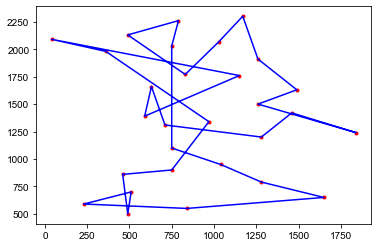

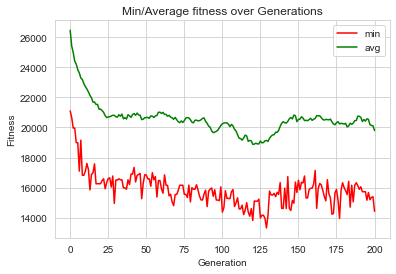

In [8]:
def GA():
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register(name="min", function=np.min)
    stats.register(name="avg", function=np.mean)

    hof = tools.HallOfFame(maxsize=HALL_OF_FAME_SIZE)

    population, logbook = algorithms.eaSimple(
        population=population,
        toolbox=toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )

    best = hof.items[0]
    print("-- Best individual =", best)
    print("-- Best fitness =", best.fitness.values[0])

    plt.figure(1)
    tsp.plotData(best)

    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red', label='min')
    plt.plot(meanFitnessValues, color='green', label='avg')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Min/Average fitness over Generations')
    plt.legend()
    plt.show()
    
GA()

## Integrate with Elitism

From the plot above, it shows that the best solutions are not being retained. Due to the low tournament size, weaker individuals are allowed to be picked. To reduce the exploration effect, a measure of exploitation has to be introduced.

Elitism mechanism allows us to keep the best solutions untouched by letting them skip the genetic operators and straight onto the next generation.

In [9]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    # Updates halloffame with the best individuals from population    
    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals, apply genetic operators
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Re-add the best individuals back to population
        offspring.extend(halloffame.items)

        # Re-update the halloffame with the newly generated population
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

gen	nevals	min    	avg    
0  	300   	21330.6	26558.6
1  	196   	20456.2	25071.3
2  	204   	19470.3	24074  
3  	203   	19358.7	23474.9
4  	205   	19358.7	22733.8
5  	219   	19226.8	22470  
6  	202   	17329.5	22004.1
7  	196   	17329.5	21506.4
8  	205   	16412.7	21002.4
9  	207   	16195.1	20580.9
10 	205   	16195.1	20273.7
11 	208   	16175  	19817.7
12 	210   	15793.6	19610.3
13 	205   	15793.6	19282.5
14 	212   	15793.6	18951.8
15 	204   	15793.6	18704.5
16 	208   	15620.3	18379.4
17 	209   	15101.7	18193.9
18 	204   	15101.7	17879.7
19 	205   	13540.9	17641.5
20 	196   	13540.9	17393.2
21 	201   	13540.9	17070  
22 	204   	13540.9	16937.1
23 	206   	13044.6	16740.5
24 	200   	13044.6	16488.3
25 	204   	13044.6	16200.5
26 	211   	13044.6	16248.4
27 	200   	13044.6	15920.8
28 	201   	12904.2	15632.5
29 	213   	12090.2	15387  
30 	205   	11524.9	15042.7
31 	203   	11524.9	14965.4
32 	209   	11524.9	14710.4
33 	206   	11524.9	14573.3
34 	201   	11524.9	14448.2
35 	199   	10855.1	14333  
3

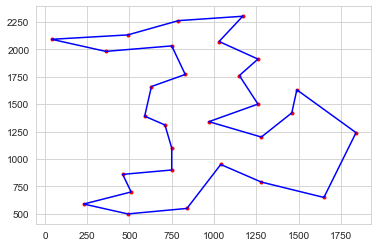

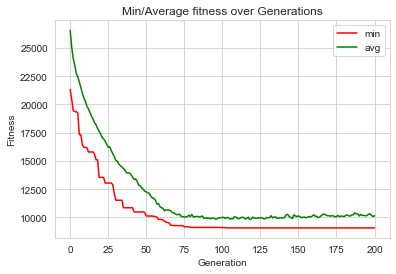

In [10]:
HALL_OF_FAME_SIZE = 75

def GA_elitism():
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register(name="min", function=np.min)
    stats.register(name="avg", function=np.mean)

    hof = tools.HallOfFame(maxsize=HALL_OF_FAME_SIZE)

    population, logbook = eaSimpleWithElitism(
        population=population,
        toolbox=toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )

    best = hof.items[0]
    print("-- Best individual =", best)
    print("-- Best fitness =", best.fitness.values[0])

    plt.figure(1)
    tsp.plotData(best)

    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red', label='min')
    plt.plot(meanFitnessValues, color='green', label='avg')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Min/Average fitness over Generations')
    plt.legend()
    plt.show()
    
GA_elitism()